In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
warnings.filterwarnings('ignore')

In [96]:
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.feature_selection import SelectKBest, f_regression, RFE, mutual_info_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
import xgboost as xgb
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import joblib

In [97]:
df = pd.read_csv('walmart_sales_cleaned.csv')
df['Date'] = pd.to_datetime(df['Date'])

print("="*80)
print("10. WALMART SALES ML FORECASTING & FEATURE ENGINEERING")
print("="*80)
print(f"Loaded cleaned dataset with {len(df)} records")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")

10. WALMART SALES ML FORECASTING & FEATURE ENGINEERING
Loaded cleaned dataset with 400491 records
Date range: 2010-02-05 00:00:00 to 2012-10-26 00:00:00


In [98]:
# Remove unnecessary index column
if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)
    print("Removed 'Unnamed: 0' column")

Removed 'Unnamed: 0' column


In [99]:
print("\n" + "="*80)
print("1. FEATURE ENGINEERING")
print("="*80)


1. FEATURE ENGINEERING


In [100]:
df_features = df.copy()

# Convert Date column if it's not already datetime
if df_features['Date'].dtype == 'object':
   df_features['Date'] = pd.to_datetime(df_features['Date'])

# 1.1 Time-based Features
print("Creating time-based features...")

# Extract comprehensive date features
df_features['Year'] = df_features['Date'].dt.year
df_features['Month'] = df_features['Date'].dt.month
df_features['Quarter'] = df_features['Date'].dt.quarter
df_features['Week'] = df_features['Date'].dt.isocalendar().week
df_features['DayOfYear'] = df_features['Date'].dt.dayofyear
df_features['WeekOfYear'] = df_features['Date'].dt.isocalendar().week
df_features['MonthStart'] = df_features['Date'].dt.is_month_start.astype(int)
df_features['MonthEnd'] = df_features['Date'].dt.is_month_end.astype(int)

# Seasonal features
df_features['Season'] = df_features['Month'].map({
   12: 'Winter', 1: 'Winter', 2: 'Winter',
   3: 'Spring', 4: 'Spring', 5: 'Spring',
   6: 'Summer', 7: 'Summer', 8: 'Summer',
   9: 'Fall', 10: 'Fall', 11: 'Fall'
})

# Cyclical encoding for temporal features
df_features['Month_sin'] = np.sin(2 * np.pi * df_features['Month'] / 12)
df_features['Month_cos'] = np.cos(2 * np.pi * df_features['Month'] / 12)
df_features['Week_sin'] = np.sin(2 * np.pi * df_features['Week'] / 52)
df_features['Week_cos'] = np.cos(2 * np.pi * df_features['Week'] / 52)
df_features['DayOfYear_sin'] = np.sin(2 * np.pi * df_features['DayOfYear'] / 365)
df_features['DayOfYear_cos'] = np.cos(2 * np.pi * df_features['DayOfYear'] / 365)


Creating time-based features...


In [101]:
# 1.2 Lag Features
print("Creating lag features...")

# Sort by store, department, and date
df_features = df_features.sort_values(['Store', 'Dept', 'Date']).reset_index(drop=True)

# Create lag features for key variables
lag_features = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
lag_periods = [1, 2, 4, 8, 12]  # 1, 2, 4, 8, 12 weeks ago

for feature in lag_features:
   for lag in lag_periods:
       df_features[f'{feature}_lag_{lag}'] = df_features.groupby(['Store', 'Dept'])[feature].shift(lag)

Creating lag features...


In [102]:
# 1.3 Rolling Window Features
print("Creating rolling window features...")

# Rolling statistics for different windows
windows = [4, 8, 12, 26]  # 4, 8, 12, 26 weeks

for feature in ['Weekly_Sales', 'Temperature', 'Fuel_Price']:
   for window in windows:
       df_features[f'{feature}_roll_mean_{window}'] = df_features.groupby(['Store', 'Dept'])[feature].transform(
           lambda x: x.rolling(window=window, min_periods=1).mean()
       )
       df_features[f'{feature}_roll_std_{window}'] = df_features.groupby(['Store', 'Dept'])[feature].transform(
           lambda x: x.rolling(window=window, min_periods=1).std()
       )
       df_features[f'{feature}_roll_max_{window}'] = df_features.groupby(['Store', 'Dept'])[feature].transform(
           lambda x: x.rolling(window=window, min_periods=1).max()
       )
       df_features[f'{feature}_roll_min_{window}'] = df_features.groupby(['Store', 'Dept'])[feature].transform(
           lambda x: x.rolling(window=window, min_periods=1).min()
       )

Creating rolling window features...


In [103]:
# 1.4 Trend and Seasonality Features
print("Creating trend and seasonality features...")

# Calculate growth rates
for feature in ['Weekly_Sales', 'Fuel_Price', 'CPI']:
   df_features[f'{feature}_growth_rate'] = df_features.groupby(['Store', 'Dept'])[feature].pct_change()
   df_features[f'{feature}_growth_rate_4w'] = df_features.groupby(['Store', 'Dept'])[feature].pct_change(periods=4)


Creating trend and seasonality features...


In [104]:
# 1.5 Store and Department Features
print("Creating store and department aggregated features...")

# Store-level aggregations
store_agg = df_features.groupby('Store').agg({
   'Weekly_Sales': ['mean', 'std', 'max', 'min'],
   'Temperature': ['mean', 'std'],
   'Size': 'first'
}).round(2)

store_agg.columns = ['Store_' + '_'.join(col).strip() for col in store_agg.columns]
store_agg = store_agg.reset_index()

# Department-level aggregations
dept_agg = df_features.groupby('Dept').agg({
   'Weekly_Sales': ['mean', 'std', 'max', 'min'],
   'Temperature': ['mean']
}).round(2)

dept_agg.columns = ['Dept_' + '_'.join(col).strip() for col in dept_agg.columns]
dept_agg = dept_agg.reset_index()

# Merge aggregated features
df_features = df_features.merge(store_agg, on='Store', how='left')
df_features = df_features.merge(dept_agg, on='Dept', how='left')


Creating store and department aggregated features...


In [105]:
# 1.6 Economic Indicator Interactions
print("Creating economic indicator interactions...")

df_features['CPI_Unemployment_Interaction'] = df_features['CPI'] * df_features['Unemployment']
df_features['Fuel_CPI_Interaction'] = df_features['Fuel_Price'] * df_features['CPI']
df_features['Temp_Fuel_Interaction'] = df_features['Temperature'] * df_features['Fuel_Price']


Creating economic indicator interactions...


In [106]:
# 1.7 Holiday and Event Features
print("Creating holiday and event features...")

# Enhanced holiday features
df_features['IsHoliday_lag1'] = df_features.groupby(['Store', 'Dept'])['IsHoliday'].shift(1)
df_features['IsHoliday_lead1'] = df_features.groupby(['Store', 'Dept'])['IsHoliday'].shift(-1)
df_features['Holiday_Effect'] = (df_features['IsHoliday'] + 
                               df_features['IsHoliday_lag1'].fillna(0) + 
                               df_features['IsHoliday_lead1'].fillna(0))


Creating holiday and event features...


In [107]:
# 1.8 Markdown Features
print("Creating markdown features...")

# Total markdowns
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
df_features['Total_MarkDown'] = df_features[markdown_cols].sum(axis=1)
df_features['MarkDown_Count'] = (df_features[markdown_cols] > 0).sum(axis=1)
df_features['Has_MarkDown'] = (df_features['Total_MarkDown'] > 0).astype(int)


Creating markdown features...


In [108]:
# Add Multi-Target Support for XGBoost
forecast_targets = ['Weekly_Sales', 'CPI', 'Fuel_Price']
for target in forecast_targets:
   # Add additional short-term lags specifically for forecasting
   for lag in [1, 2, 3]:
       if f'{target}_lag_{lag}' not in df_features.columns:
           df_features[f'{target}_lag_{lag}'] = df_features.groupby(['Store', 'Dept'])[target].shift(lag)

print(f"Feature engineering completed. Total features: {len(df_features.columns)}")

# Data Validation
print("Validating data for time series forecasting...")

# Check for missing dates in time series
date_check = df_features.groupby(['Store', 'Dept']).apply(
   lambda x: x['Date'].dt.date.nunique()
).reset_index(name='unique_dates')

print(f"Date range validation completed.")
print(f"Features ready for XGBoost: {len([col for col in df_features.columns if col not in ['Date', 'Unnamed: 0']])}")



Feature engineering completed. Total features: 135
Validating data for time series forecasting...
Date range validation completed.
Features ready for XGBoost: 134


In [109]:
print("="*80)
print("2. DATA INSPECTION AND PROBLEMATIC VALUES DETECTION")
print("="*80)

2. DATA INSPECTION AND PROBLEMATIC VALUES DETECTION


In [110]:
# Function to inspect DataFrame comprehensively
def inspect_dataframe(df, df_name="DataFrame"):
    """Comprehensive inspection of DataFrame for data quality issues"""
    
    print(f"\n{'='*60}")
    print(f"INSPECTING: {df_name}")
    print(f"{'='*60}")
    
    # Basic info
    print(f"\n1. BASIC INFORMATION:")
    print(f"   Shape: {df.shape}")
    print(f"   Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Data types
    print(f"\n2. DATA TYPES:")
    dtype_counts = df.dtypes.value_counts()
    for dtype, count in dtype_counts.items():
        print(f"   {dtype}: {count} columns")
    
    print(f"\n3. COLUMN DETAILS:")
    print("-" * 80)
    print(f"{'Column':<30} {'Type':<15} {'Non-Null':<10} {'Null%':<8} {'Issues'}")
    print("-" * 80)
    
    problematic_columns = []
    
    for col in df.columns:
        dtype = str(df[col].dtype)
        non_null = df[col].count()
        null_pct = (df[col].isna().sum() / len(df)) * 100
        
        issues = []
        
        # Check for different types of problematic values
        if df[col].dtype in ['float64', 'float32', 'int64', 'int32']:
            # Check for infinite values
            inf_positive = np.isinf(df[col]).sum() if df[col].dtype in ['float64', 'float32'] else 0
            inf_negative = np.isneginf(df[col]).sum() if df[col].dtype in ['float64', 'float32'] else 0
            
            # Check for extremely large values
            if df[col].dtype in ['float64', 'float32']:
                very_large = (np.abs(df[col]) > 1e100).sum()
                moderately_large = (np.abs(df[col]) > 1e50).sum()
            else:
                very_large = 0
                moderately_large = 0
            
            # Check for zero variance (constant values)
            if df[col].std() == 0:
                issues.append("CONSTANT")
            
            if inf_positive > 0:
                issues.append(f"+INF({inf_positive})")
                problematic_columns.append((col, 'positive_infinity', inf_positive))
            
            if inf_negative > 0:
                issues.append(f"-INF({inf_negative})")
                problematic_columns.append((col, 'negative_infinity', inf_negative))
            
            if very_large > 0:
                issues.append(f"VERY_LARGE({very_large})")
                problematic_columns.append((col, 'very_large_values', very_large))
            elif moderately_large > 0:
                issues.append(f"LARGE({moderately_large})")
        
        # Check for mixed types in object columns
        elif df[col].dtype == 'object':
            # Sample some values to check for mixed types
            sample_values = df[col].dropna().head(100)
            types_in_col = set(type(val).__name__ for val in sample_values)
            if len(types_in_col) > 1:
                issues.append(f"MIXED_TYPES{list(types_in_col)}")
        
        issues_str = ", ".join(issues) if issues else "OK"
        print(f"{col[:29]:<30} {dtype:<15} {non_null:<10} {null_pct:<7.1f} {issues_str}")
        
        if issues:
            problematic_columns.append((col, 'multiple_issues', len(issues)))
    
    return problematic_columns

# Function to get detailed statistics for problematic columns
def analyze_problematic_columns(df, problematic_cols):
    """Detailed analysis of problematic columns"""
    
    print(f"\n4. DETAILED ANALYSIS OF PROBLEMATIC COLUMNS:")
    print("="*80)
    
    if not problematic_cols:
        print("No problematic columns found!")
        return {}
    
    problem_details = {}
    
    for col_name, issue_type, count in problematic_cols:
        if col_name not in problem_details:
            problem_details[col_name] = {}
        
        print(f"\nColumn: {col_name}")
        print("-" * 40)
        
        col_data = df[col_name]
        
        # Basic stats
        print(f"Data type: {col_data.dtype}")
        print(f"Non-null count: {col_data.count()}")
        print(f"Null count: {col_data.isna().sum()}")
        
        if col_data.dtype in ['float64', 'float32', 'int64', 'int32']:
            # Numeric column analysis
            try:
                finite_data = col_data[np.isfinite(col_data)]
                if len(finite_data) > 0:
                    print(f"Min (finite): {finite_data.min()}")
                    print(f"Max (finite): {finite_data.max()}")
                    print(f"Mean (finite): {finite_data.mean():.2f}")
                    print(f"Std (finite): {finite_data.std():.2f}")
                else:
                    print("No finite values found!")
                
                # Count different types of problematic values
                pos_inf_count = np.isposinf(col_data).sum()
                neg_inf_count = np.isneginf(col_data).sum()
                very_large_count = (np.abs(col_data) > 1e100).sum()
                large_count = (np.abs(col_data) > 1e50).sum()
                
                print(f"Positive infinity: {pos_inf_count}")
                print(f"Negative infinity: {neg_inf_count}")
                print(f"Very large values (>1e100): {very_large_count}")
                print(f"Large values (>1e50): {large_count}")
                
                problem_details[col_name] = {
                    'pos_inf': pos_inf_count,
                    'neg_inf': neg_inf_count,
                    'very_large': very_large_count,
                    'large': large_count,
                    'finite_count': len(finite_data)
                }
                
                # Show some examples of problematic values
                if pos_inf_count > 0:
                    inf_indices = np.where(np.isposinf(col_data))[0][:5]
                    print(f"Sample +INF indices: {inf_indices}")
                
                if neg_inf_count > 0:
                    neginf_indices = np.where(np.isneginf(col_data))[0][:5]
                    print(f"Sample -INF indices: {neginf_indices}")
                
                if very_large_count > 0:
                    large_mask = np.abs(col_data) > 1e100
                    large_indices = np.where(large_mask)[0][:5]
                    large_values = col_data.iloc[large_indices]
                    print(f"Sample very large values: {large_values.tolist()}")
                    
            except Exception as e:
                print(f"Error analyzing column {col_name}: {e}")
        
        else:
            # Non-numeric column analysis
            print(f"Unique values: {col_data.nunique()}")
            print(f"Sample values: {col_data.dropna().head().tolist()}")
    
    return problem_details

# Function to create masks for filtering problematic rows
def create_cleaning_masks(df, problem_details):
    """Create boolean masks to identify rows with problematic values"""
    
    print(f"\n5. CREATING CLEANING MASKS:")
    print("="*60)
    
    masks = {}
    total_problematic_rows = 0
    
    # Create mask for rows with any infinite values
    inf_mask = pd.Series(False, index=df.index)
    large_mask = pd.Series(False, index=df.index)
    
    for col_name, details in problem_details.items():
        col_data = df[col_name]
        
        # Mask for infinite values in this column
        col_inf_mask = np.isinf(col_data)
        # Mask for very large values in this column
        col_large_mask = np.abs(col_data) > 1e100
        
        inf_mask |= col_inf_mask
        large_mask |= col_large_mask
        
        masks[f'{col_name}_inf'] = col_inf_mask
        masks[f'{col_name}_large'] = col_large_mask
        
        print(f"{col_name}:")
        print(f"  - Infinite values in {col_inf_mask.sum()} rows")
        print(f"  - Very large values in {col_large_mask.sum()} rows")
    
    # Combined masks
    masks['any_inf'] = inf_mask
    masks['any_large'] = large_mask
    masks['any_problematic'] = inf_mask | large_mask
    
    total_problematic_rows = masks['any_problematic'].sum()
    
    print(f"\nSUMMARY:")
    print(f"Rows with any infinite values: {inf_mask.sum()}")
    print(f"Rows with any very large values: {large_mask.sum()}")
    print(f"Total problematic rows: {total_problematic_rows}")
    print(f"Percentage of problematic rows: {(total_problematic_rows/len(df))*100:.2f}%")
    
    return masks

# Function to show sample problematic rows
def show_sample_problematic_rows(df, masks, n_samples=5):
    """Show sample rows with problematic values"""
    
    print(f"\n6. SAMPLE PROBLEMATIC ROWS:")
    print("="*80)
    
    if masks['any_problematic'].sum() == 0:
        print("No problematic rows found!")
        return
    
    problematic_rows = df[masks['any_problematic']].head(n_samples)
    
    print(f"Showing first {min(n_samples, len(problematic_rows))} problematic rows:")
    print("\nRow indices:", problematic_rows.index.tolist())
    
    # Show only columns that have issues
    problem_cols = []
    for col in df.columns:
        if df[col].dtype in ['float64', 'float32']:
            if np.isinf(problematic_rows[col]).any() or (np.abs(problematic_rows[col]) > 1e50).any():
                problem_cols.append(col)
    
    if problem_cols:
        print(f"\nProblematic columns in these rows: {problem_cols[:10]}")  # Show first 10
        print("\nSample values:")
        for idx in problematic_rows.index[:3]:  # Show first 3 rows
            print(f"\nRow {idx}:")
            for col in problem_cols[:5]:  # Show first 5 problematic columns
                val = df.loc[idx, col]
                if np.isinf(val):
                    print(f"  {col}: {val} (INFINITE)")
                elif np.abs(val) > 1e50:
                    print(f"  {col}: {val:.2e} (VERY LARGE)")
                else:
                    print(f"  {col}: {val}")

# Main inspection function
def full_data_inspection(df, df_name="df_features"):
    """Complete data inspection pipeline"""
    
    print(f"Starting comprehensive inspection of {df_name}...")
    
    # Step 1: Basic inspection
    problematic_cols = inspect_dataframe(df, df_name)
    
    # Step 2: Detailed analysis of problematic columns
    problem_details = analyze_problematic_columns(df, problematic_cols)
    
    # Step 3: Create cleaning masks
    masks = create_cleaning_masks(df, problem_details)
    
    # Step 4: Show sample problematic rows
    show_sample_problematic_rows(df, masks)
    
    # Step 5: Provide cleaning recommendations
    print(f"\n7. CLEANING RECOMMENDATIONS:")
    print("="*60)
    
    total_problematic = masks['any_problematic'].sum()
    total_rows = len(df)
    
    if total_problematic == 0:
        print("✅ No problematic values found! Data looks clean.")
    else:
        pct_problematic = (total_problematic / total_rows) * 100
        
        print(f"Found {total_problematic} problematic rows ({pct_problematic:.2f}% of data)")
        
        if pct_problematic < 1:
            print("✅ RECOMMENDATION: Drop problematic rows (< 1% of data)")
            print("   Use: df_clean = df[~masks['any_problematic']]")
        elif pct_problematic < 5:
            print("⚠️  RECOMMENDATION: Consider dropping or imputing problematic rows (< 5% of data)")
            print("   Option 1: df_clean = df[~masks['any_problematic']]")
            print("   Option 2: Apply the fixing code provided earlier")
        else:
            print("🚨 RECOMMENDATION: Use fixing code to handle problematic values (> 5% of data)")
            print("   Dropping this much data may hurt model performance")
    
    return masks, problem_details

# Execute the inspection
print("Running data inspection on df_features...")
try:
    masks, problem_details = full_data_inspection(df_features, "df_features")
    
    # Store results for later use
    print(f"\n8. RESULTS STORED:")
    print("="*40)
    print("Variables created:")
    print("- masks: Dictionary of boolean masks for filtering")
    print("- problem_details: Detailed information about problematic columns")
    print("\nTo clean your data, you can use:")
    print("df_clean = df_features[~masks['any_problematic']]")
    
except Exception as e:
    print(f"Error during inspection: {e}")
    print("Make sure df_features exists and is a pandas DataFrame")

Running data inspection on df_features...
Starting comprehensive inspection of df_features...

INSPECTING: df_features

1. BASIC INFORMATION:
   Shape: (400491, 135)
   Memory usage: 422.62 MB

2. DATA TYPES:
   float64: 115 columns
   int64: 10 columns
   int32: 4 columns
   Float64: 2 columns
   UInt32: 2 columns
   datetime64[ns]: 1 columns
   object: 1 columns

3. COLUMN DETAILS:
--------------------------------------------------------------------------------
Column                         Type            Non-Null   Null%    Issues
--------------------------------------------------------------------------------
Store                          int64           400491     0.0     OK
Date                           datetime64[ns]  400491     0.0     OK
IsHoliday                      int64           400491     0.0     OK
Dept                           float64         400491     0.0     OK
Weekly_Sales                   float64         400491     0.0     OK
Temperature                    f

In [111]:
print("Cleaning data and replacing df_features...")

# Step 1: Clean the data by removing problematic rows
df_clean = df_features[~masks['any_problematic']]

print(f"Original df_features shape: {df_features.shape}")
print(f"Cleaned data shape: {df_clean.shape}")
print(f"Removed {df_features.shape[0] - df_clean.shape[0]} problematic rows ({((df_features.shape[0] - df_clean.shape[0])/df_features.shape[0]*100):.2f}%)")

# Step 2: Replace df_features with the cleaned version
df_features = df_clean.copy()

print(f"df_features now contains clean data with shape: {df_features.shape}")

# Step 3: Verify the cleaning worked
print("\nVerifying cleaned data...")
numeric_cols = df_features.select_dtypes(include=[np.number])
inf_check = np.isinf(numeric_cols).any().any()
large_check = (np.abs(numeric_cols) > 1e100).any().any()

print(f"✅ Any infinite values remaining: {inf_check}")
print(f"✅ Any very large values remaining: {large_check}")

Cleaning data and replacing df_features...
Original df_features shape: (400491, 135)
Cleaned data shape: (400366, 135)
Removed 125 problematic rows (0.03%)
df_features now contains clean data with shape: (400366, 135)

Verifying cleaned data...
✅ Any infinite values remaining: False
✅ Any very large values remaining: False


In [112]:
print("\n" + "="*80)
print("3. CORRELATION ANALYSIS FOR FEATURE SELECTION")
print("="*80)


3. CORRELATION ANALYSIS FOR FEATURE SELECTION


Analyzing correlations for 125 numeric features...


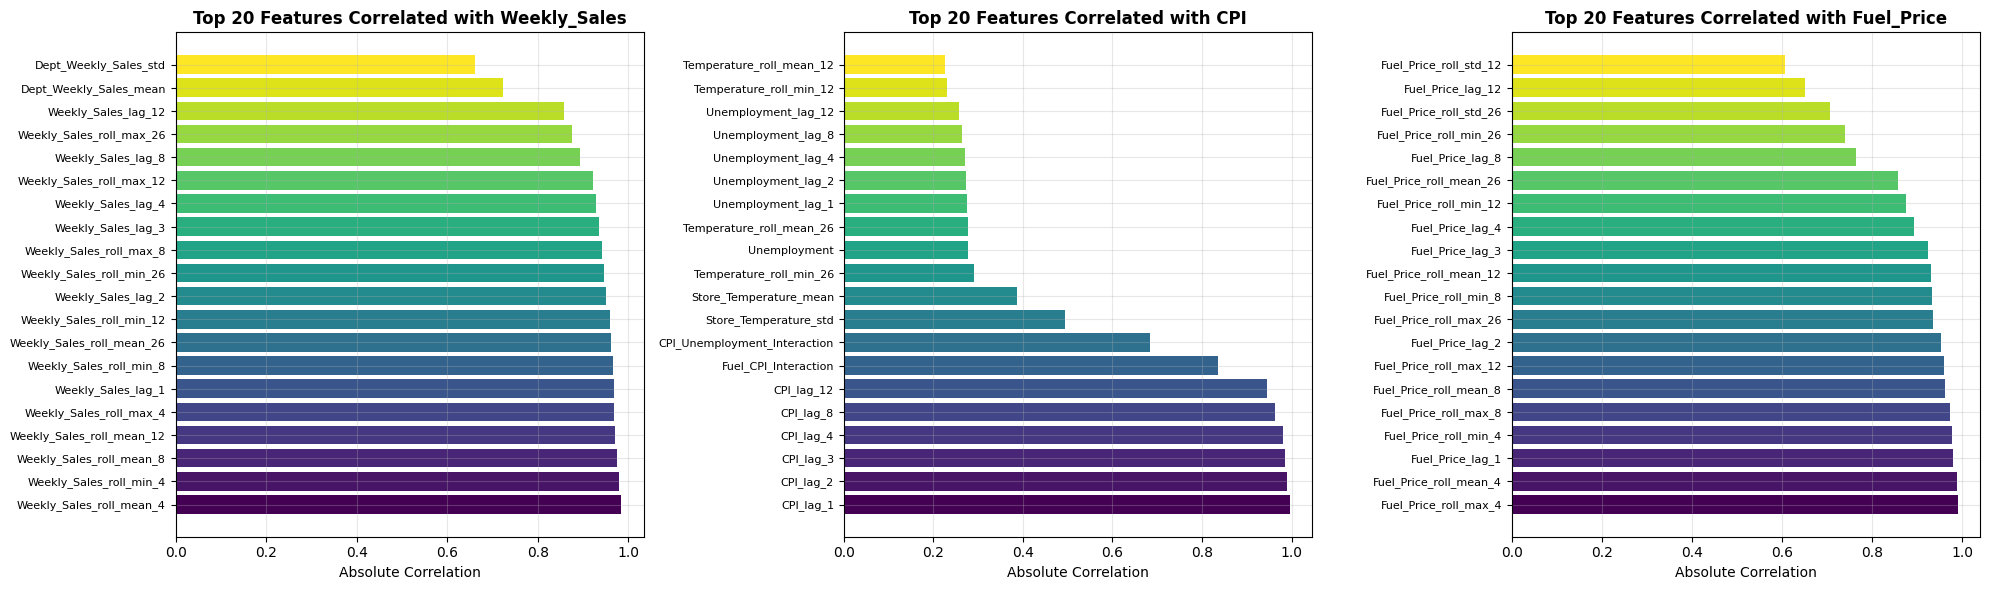

In [113]:
from scipy.stats import pearsonr

numeric_features = df_features.select_dtypes(include=[np.number]).columns.tolist()

# Remove target variables and ID columns
exclude_cols = ['Store', 'Dept', 'Year', 'Month', 'Week', 'Quarter', 'DayOfYear', 'WeekOfYear', 'Unnamed: 0']
analysis_features = [col for col in numeric_features if col not in exclude_cols]

# Fill missing values for correlation analysis
df_corr = df_features[analysis_features].fillna(df_features[analysis_features].median())

print(f"Analyzing correlations for {len(analysis_features)} numeric features...")

# 2.1 Correlation with target variables
target_variables = ['Weekly_Sales', 'CPI', 'Fuel_Price']

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for i, target in enumerate(target_variables):
   
   correlations = []
   feature_names = []
   
   for feature in analysis_features:
       if feature != target:
           corr, _ = pearsonr(df_corr[feature], df_corr[target])
           if not np.isnan(corr):
               correlations.append(abs(corr))
               feature_names.append(feature)
   
   # Sort by correlation strength
   corr_data = list(zip(feature_names, correlations))
   corr_data.sort(key=lambda x: x[1], reverse=True)
   
   # Plot top 20 correlations
   top_features = corr_data[:20]
   features, corrs = zip(*top_features)
   
   axes[i].barh(range(len(features)), corrs, color=plt.cm.viridis(np.linspace(0, 1, len(features))))
   axes[i].set_yticks(range(len(features)))
   axes[i].set_yticklabels(features, fontsize=8)
   axes[i].set_xlabel('Absolute Correlation')
   axes[i].set_title(f'Top 20 Features Correlated with {target}', fontweight='bold')
   axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Creating correlation heatmap for top features...


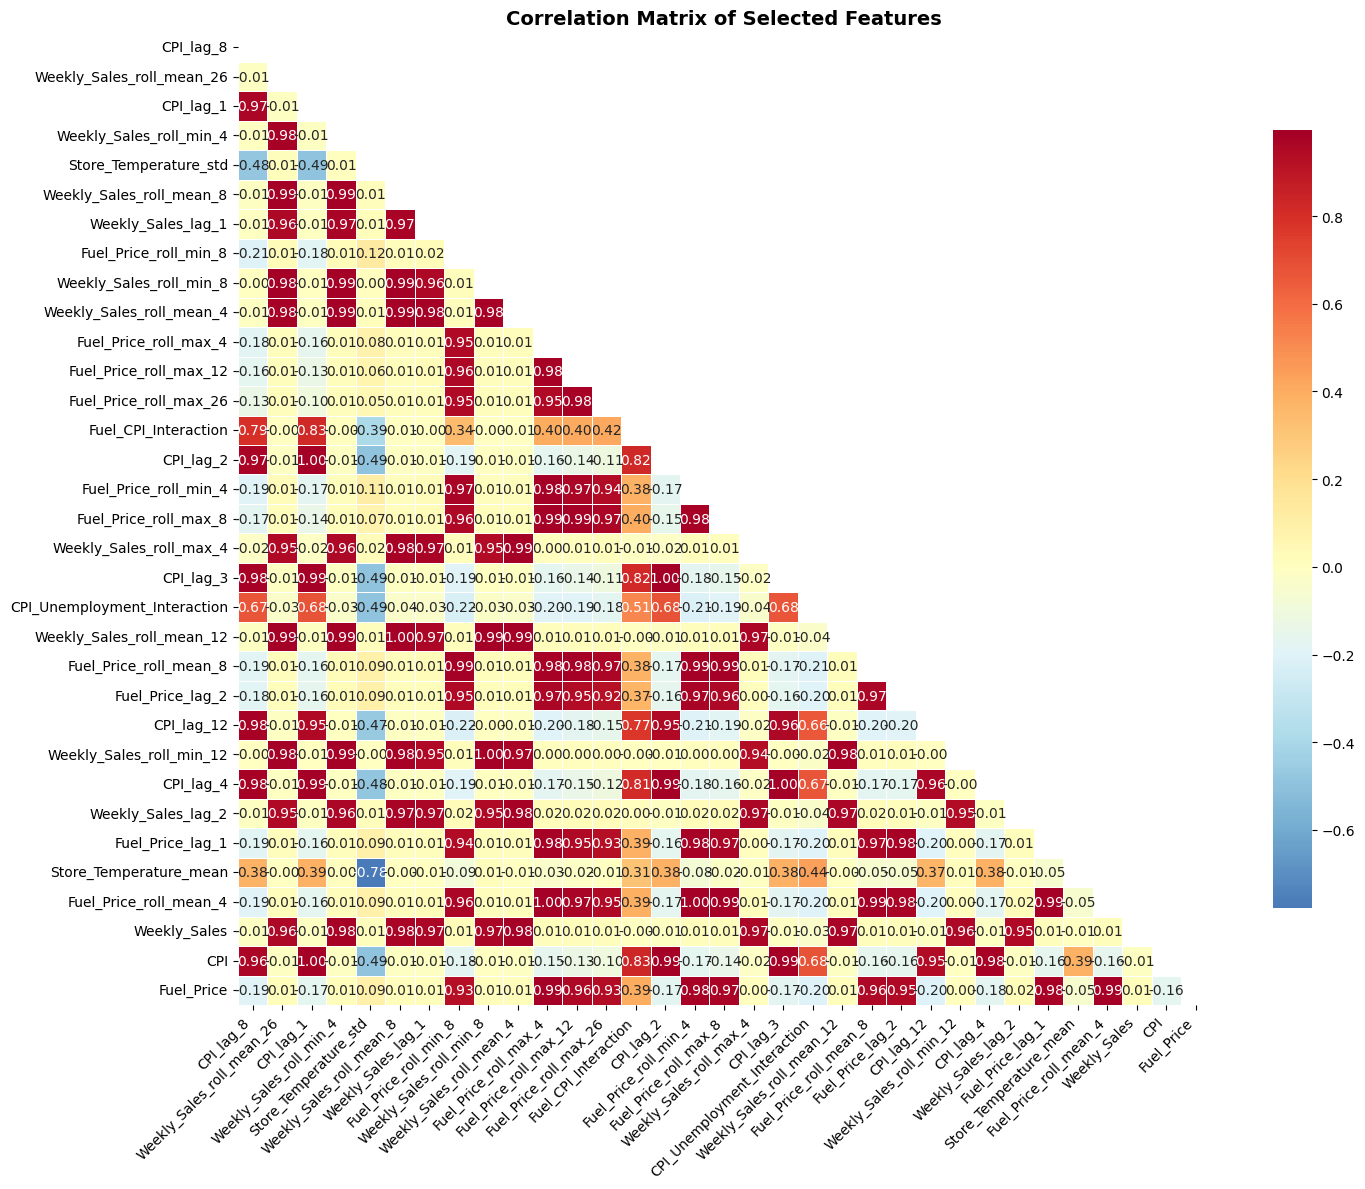

In [114]:
# 2.2 Feature correlation heatmap (top features)
print("\nCreating correlation heatmap for top features...")

# Select top correlated features for each target
top_features_all = set()
for target in target_variables:
   correlations = []
   for feature in analysis_features:
       if feature != target:
           corr, _ = pearsonr(df_corr[feature], df_corr[target])
           if not np.isnan(corr):
               correlations.append((feature, abs(corr)))
   
   correlations.sort(key=lambda x: x[1], reverse=True)
   top_features_all.update([feat[0] for feat in correlations[:10]])

# Add target variables
selected_features = list(top_features_all) + target_variables
correlation_matrix = df_corr[selected_features].corr()

plt.figure(figsize=(15, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdYlBu_r', center=0,
           square=True, linewidths=.5, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Selected Features', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [115]:
print("\n" + "="*80)
print("4. FEATURE SELECTION")
print("="*80)


4. FEATURE SELECTION


In [116]:
def prepare_features_for_selection(df, target_col, model_type='xgboost'):
    """Prepare features for selection by handling missing values and encoding"""
    df_prep = df.copy()
    
    # Fill missing values
    numeric_cols = df_prep.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        df_prep[col] = df_prep[col].fillna(df_prep[col].median())
    
    # Encode categorical variables
    categorical_cols = ['Season']
    le = LabelEncoder()
    for col in categorical_cols:
        if col in df_prep.columns:
            df_prep[col + '_encoded'] = le.fit_transform(df_prep[col].astype(str))
    
        # Only exclude non-predictive columns
    exclude_cols = [
            'Date', 'Season'  # Keep numeric encodings, remove only categorical and date
        ] + [col for col in df_prep.columns if 'Unnamed' in col]
    feature_cols = [col for col in df_prep.columns if col not in exclude_cols + [target_col]]
    
    X = df_prep[feature_cols]
    y = df_prep[target_col]
    
    return X, y, feature_cols

In [117]:
# XGBoost Feature selection for multiple targets
print("="*60)
print("XGBOOST FEATURE SELECTION")
print("="*60)

from xgboost import XGBRegressor

xgboost_targets = ['Weekly_Sales', 'CPI', 'Fuel_Price']
xgboost_feature_results = {}

for target in xgboost_targets:
    print(f"\nXGBoost feature selection for {target}:")
    print("-" * 50)
    
    X, y, feature_cols = prepare_features_for_selection(df_features, target, model_type='xgboost')
    
    # Remove highly correlated features first
    corr_matrix = X.corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    high_corr_features = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
    X_reduced = X.drop(columns=high_corr_features)
    
    print(f"Removed {len(high_corr_features)} highly correlated features (>0.95)")
    print(f"Features remaining: {X_reduced.shape[1]}")
    
    # XGBoost-specific feature selection
    # 1. Univariate Feature Selection
    selector_univariate = SelectKBest(score_func=f_regression, k=min(50, X_reduced.shape[1]))
    X_univariate = selector_univariate.fit_transform(X_reduced, y)
    univariate_features = X_reduced.columns[selector_univariate.get_support()].tolist()
    
    # 2. XGBoost Feature Importance
    xgb_regressor = XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
    xgb_regressor.fit(X_reduced, y)
    xgb_importance = pd.DataFrame({
        'feature': X_reduced.columns,
        'importance': xgb_regressor.feature_importances_
    }).sort_values('importance', ascending=False)
    
    xgb_top_features = xgb_importance.head(min(40, len(xgb_importance)))['feature'].tolist()
    
    # 3. Mutual Information
    selector_mi = SelectKBest(score_func=mutual_info_regression, k=min(35, X_reduced.shape[1]))
    X_mi = selector_mi.fit_transform(X_reduced, y)
    mi_features = X_reduced.columns[selector_mi.get_support()].tolist()
    
    # Combine all methods for XGBoost
    all_selected_features = set(univariate_features + xgb_top_features + mi_features)
    final_features = list(all_selected_features)
    
    xgboost_feature_results[target] = {
        'univariate': univariate_features,
        'xgboost_importance': xgb_top_features,
        'mutual_info': mi_features,
        'final_combined': final_features
    }
    
    print(f"Univariate selection: {len(univariate_features)} features")
    print(f"XGBoost importance selection: {len(xgb_top_features)} features")
    print(f"Mutual Info selection: {len(mi_features)} features")
    print(f"Combined final selection: {len(final_features)} features")


XGBOOST FEATURE SELECTION

XGBoost feature selection for Weekly_Sales:
--------------------------------------------------
Removed 60 highly correlated features (>0.95)
Features remaining: 73
Univariate selection: 50 features
XGBoost importance selection: 40 features
Mutual Info selection: 35 features
Combined final selection: 62 features

XGBoost feature selection for CPI:
--------------------------------------------------
Removed 60 highly correlated features (>0.95)
Features remaining: 73
Univariate selection: 50 features
XGBoost importance selection: 40 features
Mutual Info selection: 35 features
Combined final selection: 62 features

XGBoost feature selection for Fuel_Price:
--------------------------------------------------
Removed 60 highly correlated features (>0.95)
Features remaining: 73
Univariate selection: 50 features
XGBoost importance selection: 40 features
Mutual Info selection: 35 features
Combined final selection: 60 features


In [118]:
print("\n" + "="*80)
print("5. FORECASTING MODELS")
print("="*80)


5. FORECASTING MODELS


In [119]:
def calculate_metrics(y_true, y_pred):
    """Calculate comprehensive evaluation metrics"""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    # Fix MAPE calculation to handle zero values
    mask = y_true != 0  # Only calculate MAPE for non-zero actual values
    if mask.sum() > 0:  # If there are non-zero values
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        mape = np.nan  # If all values are zero
    
    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'MAPE': mape
    }

def prepare_time_series_data_consistent(df, target_col, selected_features, test_size=0.2):
    """Prepare data using the same preprocessing as feature selection"""
    df_prep = df.copy()
    
    # Apply the SAME preprocessing as in prepare_features_for_selection
    # Fill missing values
    numeric_cols = df_prep.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        df_prep[col] = df_prep[col].fillna(df_prep[col].median())
    
    # Encode categorical variables (same as feature selection)
    categorical_cols = ['Season']
    le = LabelEncoder()
    for col in categorical_cols:
        if col in df_prep.columns:
            df_prep[col + '_encoded'] = le.fit_transform(df_prep[col].astype(str))
    
    # Sort by Store, Dept, and Date
    df_sorted = df_prep.sort_values(['Store', 'Dept', 'Date']).reset_index(drop=True)
    
    # Remove rows with missing target values
    df_clean = df_sorted.dropna(subset=[target_col])
    
    # IMPORTANT: Apply the same correlation filtering as in feature selection
    # This ensures consistency with the XGBoost feature selection process
    available_features = [col for col in selected_features if col in df_clean.columns]
    
    if len(available_features) > 1:
        # Create feature matrix for correlation check
        X_for_corr = df_clean[available_features]
        
        # Remove highly correlated features (>0.95) - same as feature selection
        corr_matrix = X_for_corr.corr().abs()
        upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        high_corr_features = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
        
        # Remove highly correlated features from selected_features
        final_features = [col for col in available_features if col not in high_corr_features]
        
        print(f"Removed {len(high_corr_features)} highly correlated features during data preparation")
        print(f"Final features for modeling: {len(final_features)}")
    else:
        final_features = available_features
    
    # Prepare features and target with final feature set
    X = df_clean[final_features]
    y = df_clean[target_col]
    dates = df_clean['Date']
    
    # Time series split
    split_index = int(len(df_clean) * (1 - test_size))
    
    X_train = X.iloc[:split_index]
    X_test = X.iloc[split_index:]
    y_train = y.iloc[:split_index]
    y_test = y.iloc[split_index:]
    dates_train = dates.iloc[:split_index]
    dates_test = dates.iloc[split_index:]
    
    return X_train, X_test, y_train, y_test, dates_train, dates_test

In [134]:
print("="*80)
print("XGBOOST TIME SERIES FORECASTING")
print("="*80)

# XGBoost models for multiple targets
xgboost_results = {}
xgboost_models = {}

for target in ['Weekly_Sales', 'CPI', 'Fuel_Price']:
    print(f"\nBuilding XGBoost model for {target}...")
    print("-" * 50)
    
    # Get selected features for this target - CORRECTED VARIABLE NAME
    selected_features = xgboost_feature_results[target]['final_combined']
    print(f"Using {len(selected_features)} selected features")
    
    # Prepare data
    X_train, X_test, y_train, y_test, dates_train, dates_test = prepare_time_series_data_consistent(
        df_features, target, selected_features
    )
    
    print(f"Training data: {X_train.shape}")
    print(f"Testing data: {X_test.shape}")
    
    # Build XGBoost model
    xgb_model = XGBRegressor(
        n_estimators=500,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        reg_alpha=1.0,             
        reg_lambda=1.0,            
        min_child_weight=3,        
        verbosity=0    )
    
    # Train model
    xgb_model.fit(X_train, y_train)

    
    # Make predictions
    y_pred_train = xgb_model.predict(X_train)
    y_pred_test = xgb_model.predict(X_test)
    
    # Calculate metrics
    train_metrics = calculate_metrics(y_train, y_pred_train)
    test_metrics = calculate_metrics(y_test, y_pred_test)
    
    # Store results
    xgboost_results[target] = {
        'model': xgb_model,
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'y_train': y_train,
        'y_test': y_test,
        'y_pred_train': y_pred_train,
        'y_pred_test': y_pred_test,
        'dates_train': dates_train,
        'dates_test': dates_test,
        'features': selected_features
    }
    
    # Store model separately for easy access
    xgboost_models[target] = xgb_model
    
    print(f"\nTraining Metrics:")
    for metric, value in train_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    print(f"\nTesting Metrics:")
    for metric, value in test_metrics.items():
        print(f"{metric}: {value:.4f}")

XGBOOST TIME SERIES FORECASTING

Building XGBoost model for Weekly_Sales...
--------------------------------------------------
Using 62 selected features
Removed 0 highly correlated features during data preparation
Final features for modeling: 62
Training data: (320292, 62)
Testing data: (80074, 62)

Training Metrics:
MAE: 161.3962
MSE: 68526.3033
RMSE: 261.7753
R2: 0.9997
MAPE: 149.0856

Testing Metrics:
MAE: 143.6735
MSE: 98081.3064
RMSE: 313.1794
R2: 0.9996
MAPE: 133.1682

Building XGBoost model for CPI...
--------------------------------------------------
Using 62 selected features
Removed 0 highly correlated features during data preparation
Final features for modeling: 62
Training data: (320292, 62)
Testing data: (80074, 62)

Training Metrics:
MAE: 0.0187
MSE: 0.0013
RMSE: 0.0367
R2: 1.0000
MAPE: 0.0112

Testing Metrics:
MAE: 1.4845
MSE: 6.2359
RMSE: 2.4972
R2: 0.9954
MAPE: 0.9186

Building XGBoost model for Fuel_Price...
--------------------------------------------------
Using 60

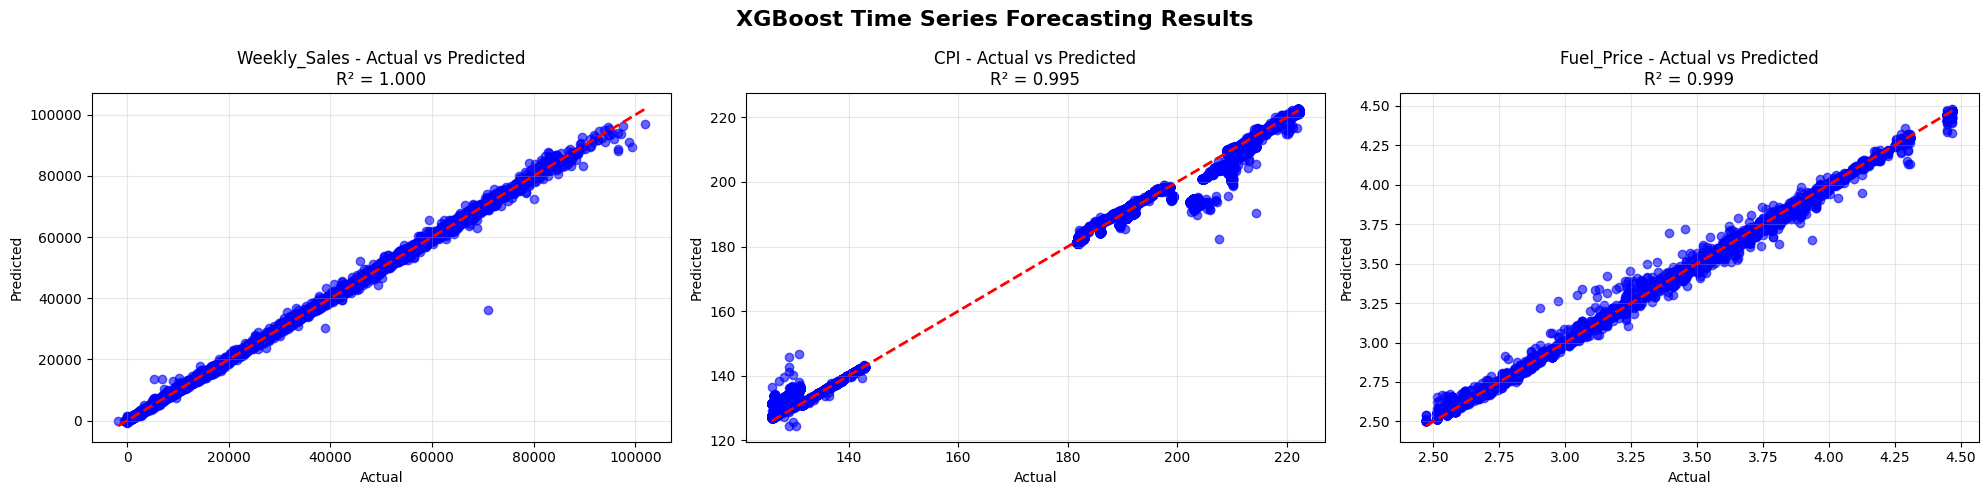

In [135]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('XGBoost Time Series Forecasting Results', fontsize=16, fontweight='bold')

for i, target in enumerate(['Weekly_Sales', 'CPI', 'Fuel_Price']):
    results = xgboost_results[target]
    
    # Plot: Actual vs Predicted (Test Set)
    axes[i].scatter(results['y_test'], results['y_pred_test'], alpha=0.6, color='blue')
    axes[i].plot([results['y_test'].min(), results['y_test'].max()], 
                 [results['y_test'].min(), results['y_test'].max()], 'r--', lw=2)
    axes[i].set_xlabel('Actual')
    axes[i].set_ylabel('Predicted')
    axes[i].set_title(f'{target} - Actual vs Predicted\nR² = {results["test_metrics"]["R2"]:.3f}')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


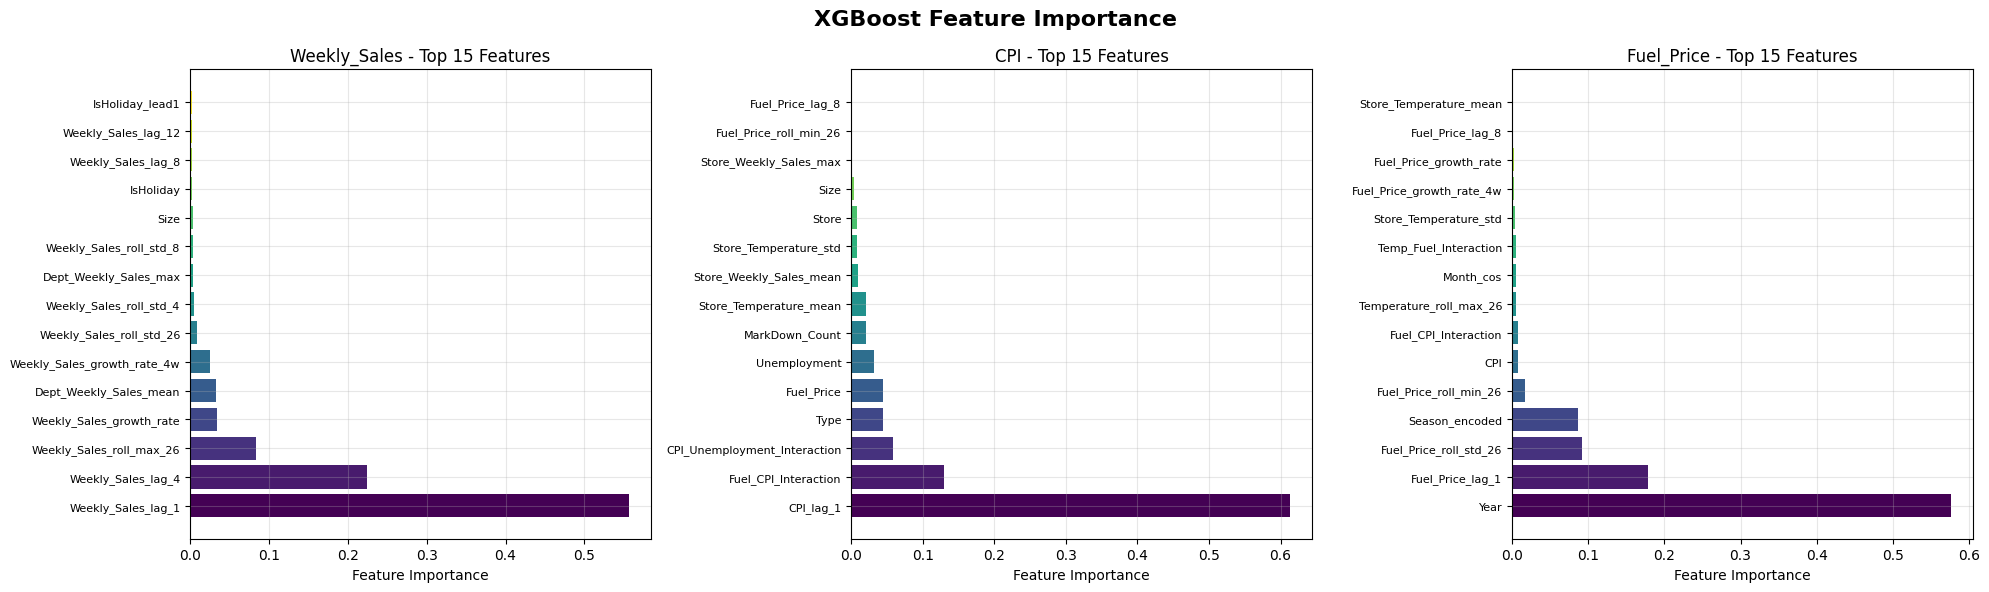

In [136]:
# Feature importance for XGBoost models
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('XGBoost Feature Importance', fontsize=16, fontweight='bold')

for i, target in enumerate(['Weekly_Sales', 'CPI', 'Fuel_Price']):
    model = xgboost_results[target]['model']
    features = xgboost_results[target]['features']
    
    importance_df = pd.DataFrame({
        'feature': features,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False).head(15)
    
    axes[i].barh(range(len(importance_df)), importance_df['importance'], 
                 color=plt.cm.viridis(np.linspace(0, 1, len(importance_df))))
    axes[i].set_yticks(range(len(importance_df)))
    axes[i].set_yticklabels(importance_df['feature'], fontsize=8)
    axes[i].set_xlabel('Feature Importance')
    axes[i].set_title(f'{target} - Top 15 Features')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [137]:
print("\nXGBoost Results:")
print("-" * 30)
for target in ['Weekly_Sales', 'CPI', 'Fuel_Price']:
    metrics = xgboost_results[target]['test_metrics']
    print(f"\n{target}:")
    print(f"  R² Score: {metrics['R2']:.4f}")
    print(f"  RMSE: {metrics['RMSE']:.4f}")
    print(f"  MAE: {metrics['MAE']:.4f}")


XGBoost Results:
------------------------------

Weekly_Sales:
  R² Score: 0.9996
  RMSE: 313.1794
  MAE: 143.6735

CPI:
  R² Score: 0.9954
  RMSE: 2.4972
  MAE: 1.4845

Fuel_Price:
  R² Score: 0.9993
  RMSE: 0.0116
  MAE: 0.0070


Creating Actual vs Predicted line charts for last limited period...


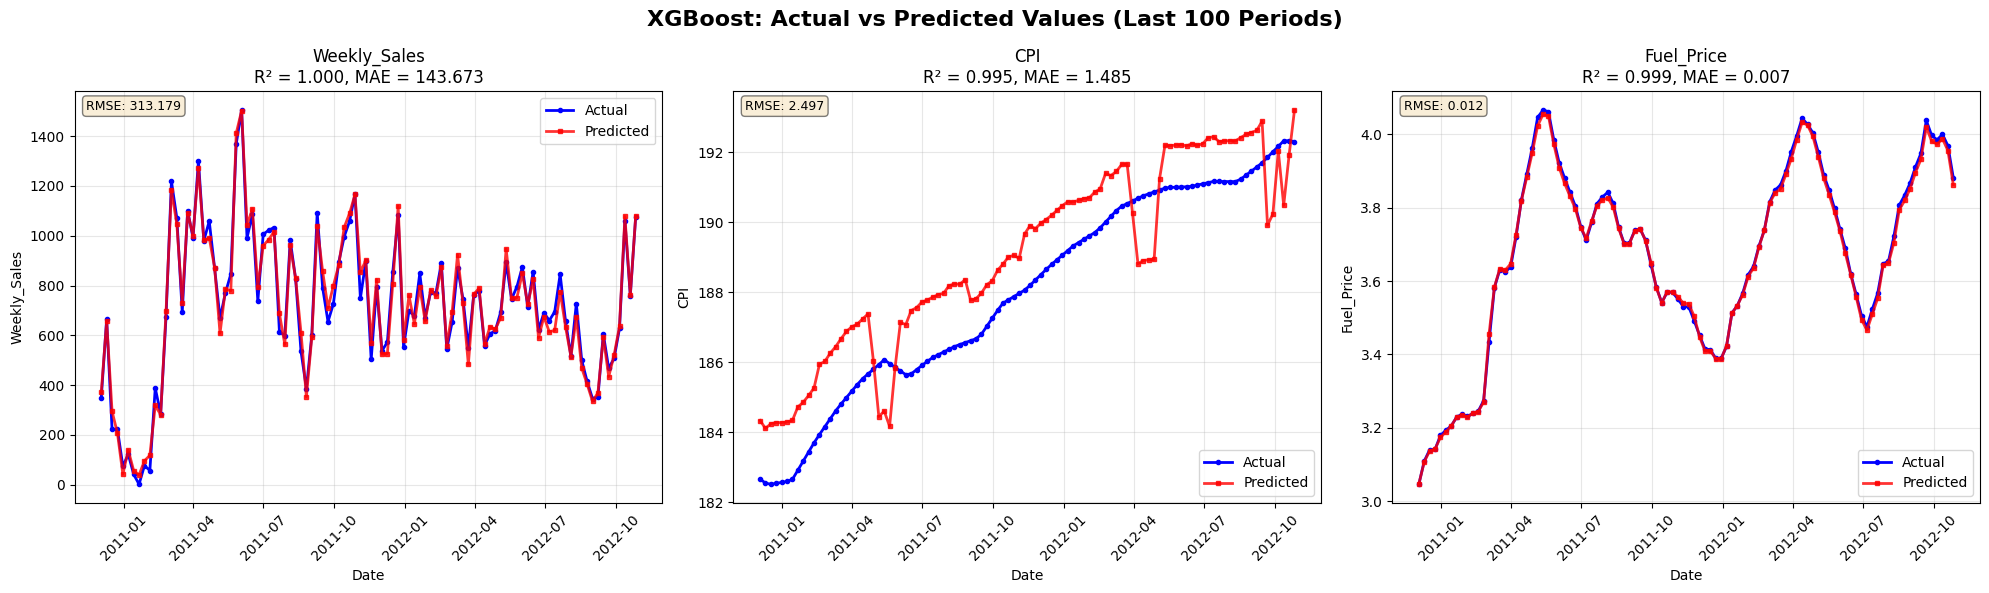

In [138]:
# 1. Actual vs Predicted Line Charts for Last Limited Period (3 targets in one plot)
print("Creating Actual vs Predicted line charts for last limited period...")

# Set the number of recent periods to display
recent_periods = 100  # Adjust this number as needed

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('XGBoost: Actual vs Predicted Values (Last 100 Periods)', fontsize=16, fontweight='bold')

for i, target in enumerate(['Weekly_Sales', 'CPI', 'Fuel_Price']):
    results = xgboost_results[target]
    
    # Get last N periods from test set
    end_idx = len(results['dates_test'])
    start_idx = max(0, end_idx - recent_periods)
    
    recent_dates = results['dates_test'].iloc[start_idx:end_idx]
    recent_actual = results['y_test'].iloc[start_idx:end_idx]
    recent_predicted = results['y_pred_test'][start_idx:end_idx]  # numpy array indexing
    
    # Plot actual vs predicted
    axes[i].plot(recent_dates, recent_actual, 
                label='Actual', color='blue', linewidth=2, marker='o', markersize=3)
    axes[i].plot(recent_dates, recent_predicted, 
                label='Predicted', color='red', linewidth=2, marker='s', markersize=3, alpha=0.8)
    
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(target)
    axes[i].set_title(f'{target}\nR² = {results["test_metrics"]["R2"]:.3f}, MAE = {results["test_metrics"]["MAE"]:.3f}')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)
    axes[i].tick_params(axis='x', rotation=45)
    
    # Add text with metrics
    axes[i].text(0.02, 0.98, f'RMSE: {results["test_metrics"]["RMSE"]:.3f}', 
                transform=axes[i].transAxes, fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

Creating individual forecast charts for each target...


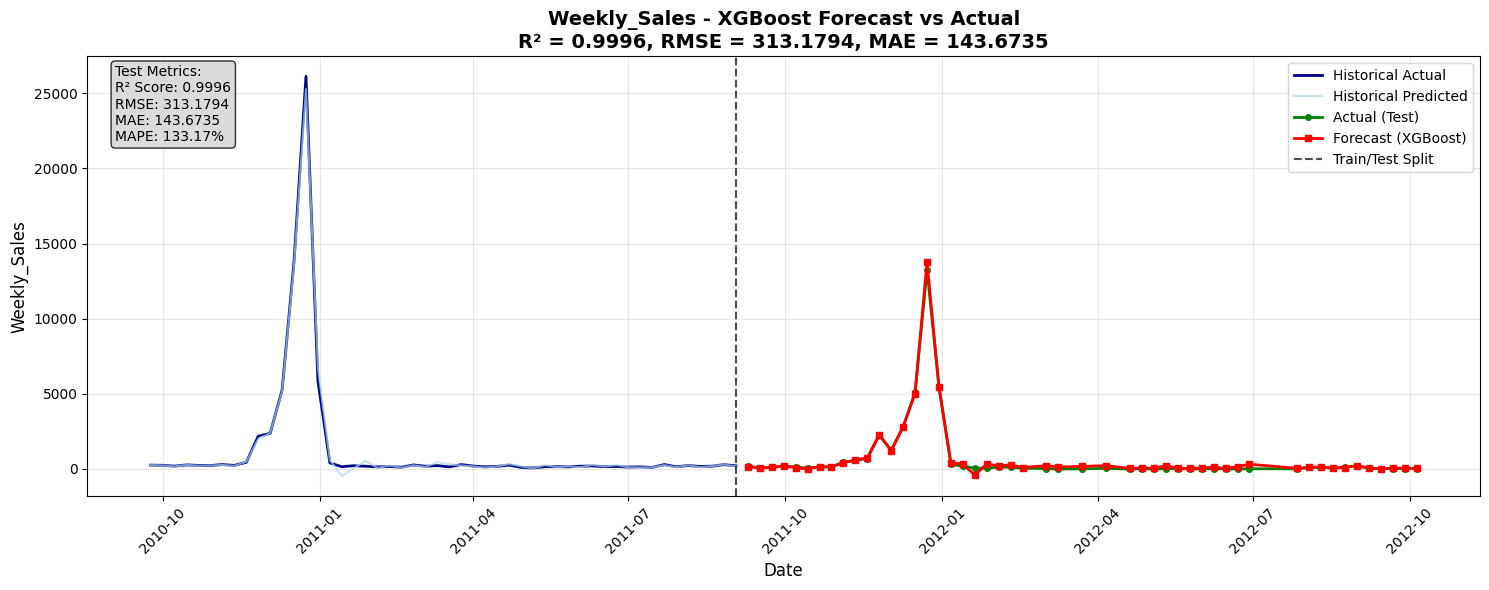

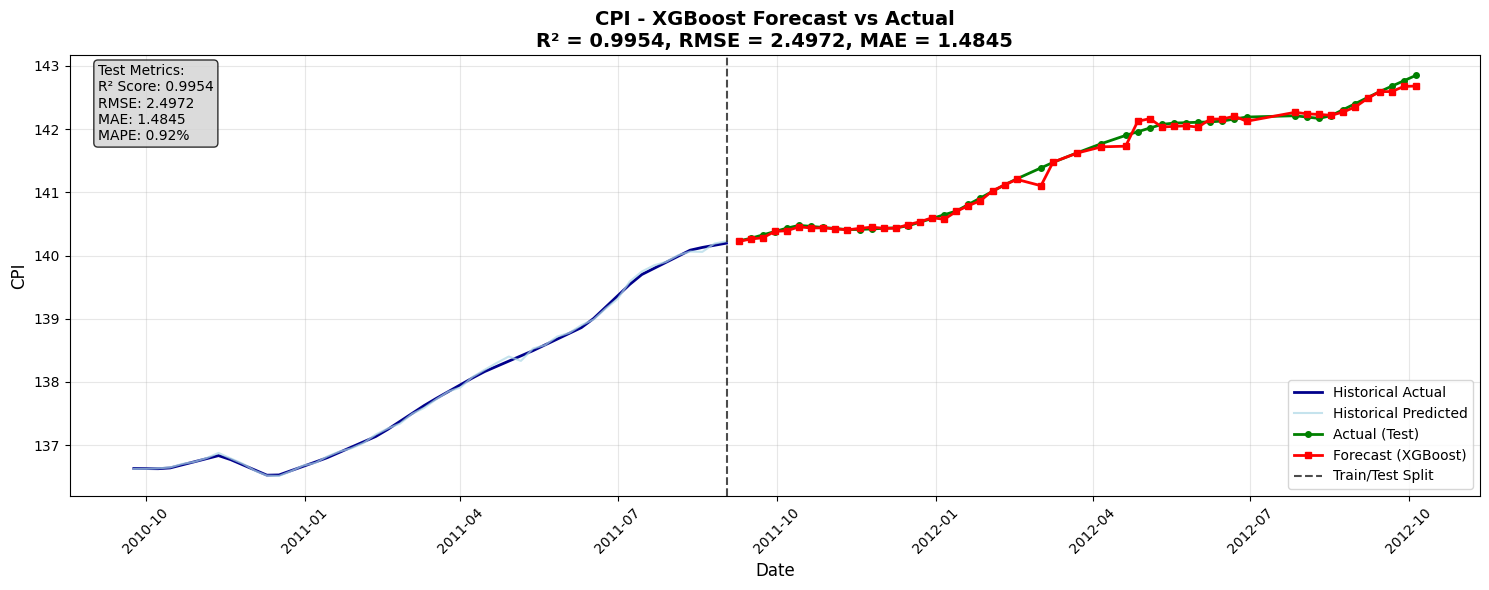

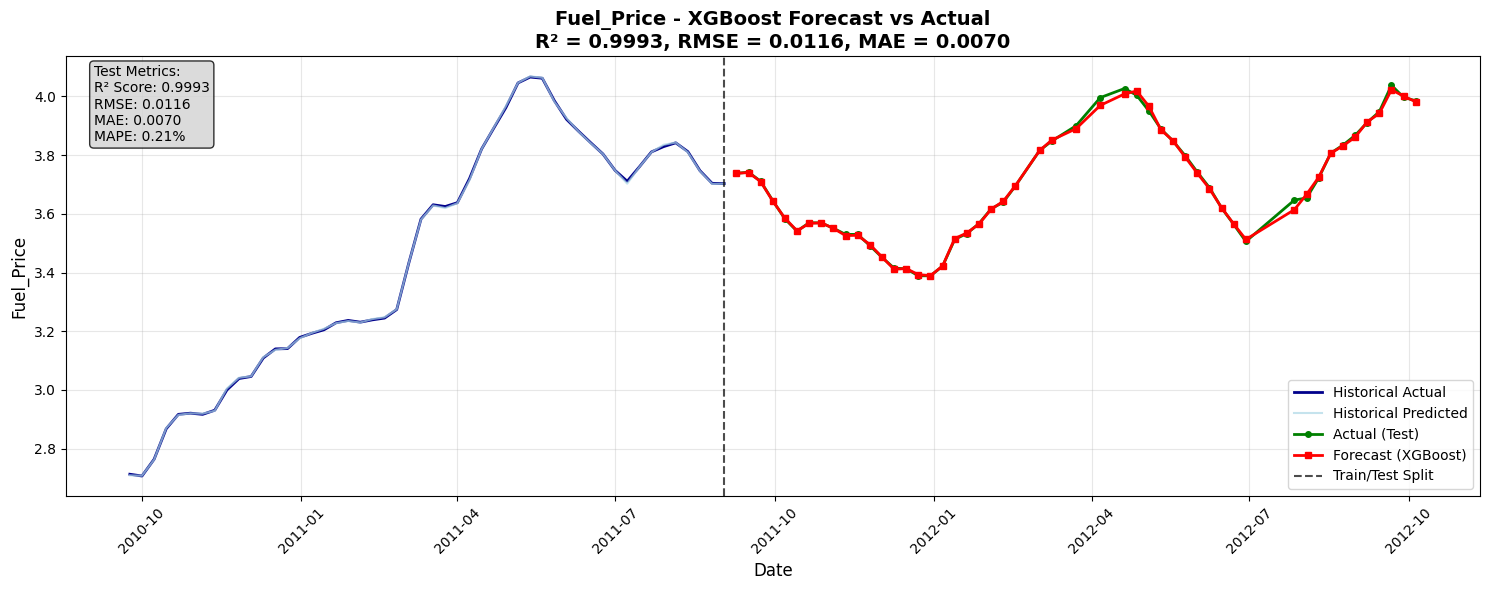

Creating forecast quality analysis...


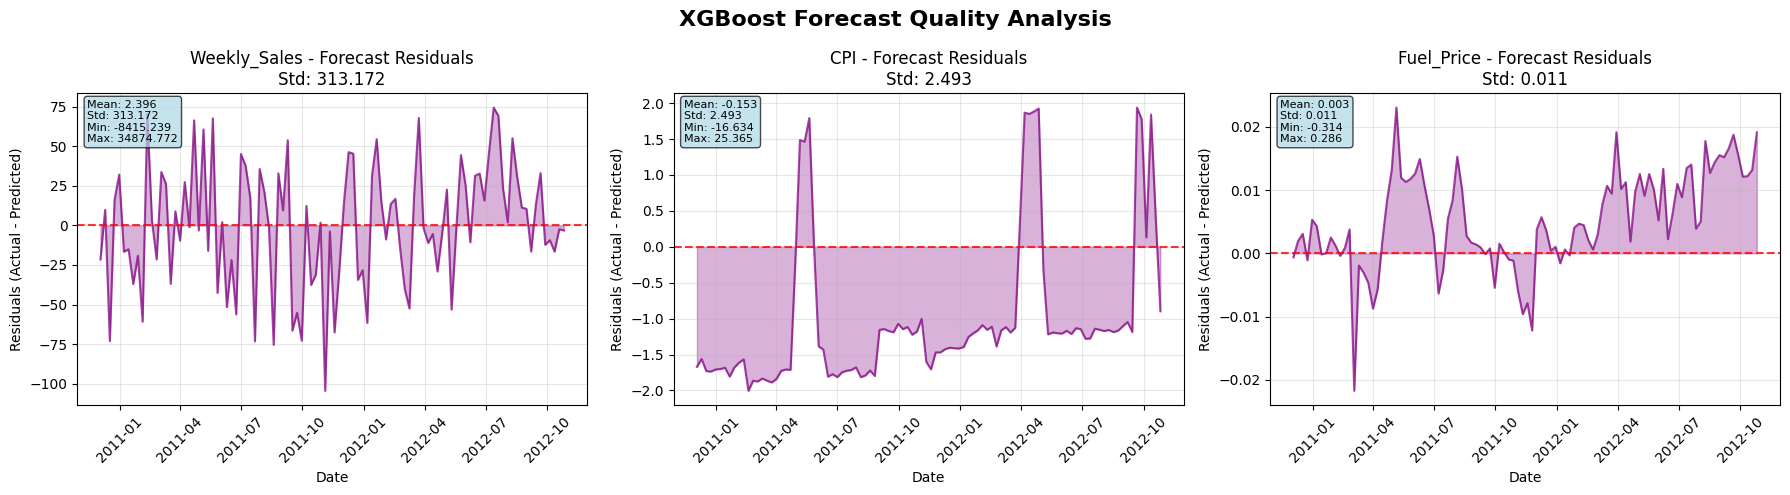


Summary of visualizations created:
1. Actual vs Predicted comparison for last 100 periods
2. Individual forecast charts for each target
3. Forecast residuals analysis


In [139]:
# 2. Individual Forecast Charts for Each Target (3 separate plots)
print("Creating individual forecast charts for each target...")

for target in ['Weekly_Sales', 'CPI', 'Fuel_Price']:
    results = xgboost_results[target]
    
    # Set periods for display
    train_periods = 50  # Last 50 periods from training
    test_periods = 50   # First 50 periods from testing (or all if less)
    
    # Get training data (last N periods)
    train_end = len(results['dates_train'])
    train_start = max(0, train_end - train_periods)
    
    train_dates_recent = results['dates_train'].iloc[train_start:train_end]
    train_actual_recent = results['y_train'].iloc[train_start:train_end]
    train_pred_recent = results['y_pred_train'][train_start:train_end]  # numpy array indexing
    
    # Get test data (first N periods)
    test_end = min(len(results['dates_test']), test_periods)
    
    test_dates_recent = results['dates_test'].iloc[:test_end]
    test_actual_recent = results['y_test'].iloc[:test_end]
    test_pred_recent = results['y_pred_test'][:test_end]  # numpy array indexing
    
    # Create the plot
    plt.figure(figsize=(15, 6))
    
    # Plot training period
    plt.plot(train_dates_recent, train_actual_recent, 
             label='Historical Actual', color='darkblue', linewidth=2)
    plt.plot(train_dates_recent, train_pred_recent, 
             label='Historical Predicted', color='lightblue', linewidth=1.5, alpha=0.7)
    
    # Plot test period (forecast)
    plt.plot(test_dates_recent, test_actual_recent, 
             label='Actual (Test)', color='green', linewidth=2, marker='o', markersize=4)
    plt.plot(test_dates_recent, test_pred_recent, 
             label='Forecast (XGBoost)', color='red', linewidth=2, marker='s', markersize=4)
    
    # Add vertical line to separate train/test
    if len(train_dates_recent) > 0 and len(test_dates_recent) > 0:
        split_date = train_dates_recent.iloc[-1]
        plt.axvline(x=split_date, color='black', linestyle='--', alpha=0.7, 
                   label='Train/Test Split')
    
    # Formatting
    plt.xlabel('Date', fontsize=12)
    plt.ylabel(target, fontsize=12)
    plt.title(f'{target} - XGBoost Forecast vs Actual\n'
              f'R² = {results["test_metrics"]["R2"]:.4f}, '
              f'RMSE = {results["test_metrics"]["RMSE"]:.4f}, '
              f'MAE = {results["test_metrics"]["MAE"]:.4f}', 
              fontsize=14, fontweight='bold')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    # Add performance metrics box
    metrics_text = f'Test Metrics:\nR² Score: {results["test_metrics"]["R2"]:.4f}\n' \
                  f'RMSE: {results["test_metrics"]["RMSE"]:.4f}\n' \
                  f'MAE: {results["test_metrics"]["MAE"]:.4f}'
    
    if not np.isinf(results["test_metrics"]["MAPE"]) and not np.isnan(results["test_metrics"]["MAPE"]):
        metrics_text += f'\nMAPE: {results["test_metrics"]["MAPE"]:.2f}%'
    
    plt.text(0.02, 0.98, metrics_text, transform=plt.gca().transAxes, 
             fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# 3. Forecast Quality Analysis
print("Creating forecast quality analysis...")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('XGBoost Forecast Quality Analysis', fontsize=16, fontweight='bold')

for i, target in enumerate(['Weekly_Sales', 'CPI', 'Fuel_Price']):
    results = xgboost_results[target]
    
    # Calculate residuals
    residuals = results['y_test'] - pd.Series(results['y_pred_test'], index=results['y_test'].index)
    
    # Plot residuals over time
    recent_periods = min(100, len(results['dates_test']))
    recent_dates = results['dates_test'].iloc[-recent_periods:]
    recent_residuals = residuals.iloc[-recent_periods:]
    
    axes[i].plot(recent_dates, recent_residuals, 
                color='purple', linewidth=1.5, alpha=0.7)
    axes[i].axhline(y=0, color='red', linestyle='--', alpha=0.8)
    axes[i].fill_between(recent_dates, recent_residuals, 0, 
                        alpha=0.3, color='purple')
    
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Residuals (Actual - Predicted)')
    axes[i].set_title(f'{target} - Forecast Residuals\nStd: {residuals.std():.3f}')
    axes[i].grid(True, alpha=0.3)
    axes[i].tick_params(axis='x', rotation=45)
    
    # Add residual statistics
    residual_stats = f'Mean: {residuals.mean():.3f}\nStd: {residuals.std():.3f}\nMin: {residuals.min():.3f}\nMax: {residuals.max():.3f}'
    axes[i].text(0.02, 0.98, residual_stats, transform=axes[i].transAxes, 
                fontsize=8, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

plt.tight_layout()
plt.show()

print(f"\nSummary of visualizations created:")
print(f"1. Actual vs Predicted comparison for last {recent_periods} periods")
print(f"2. Individual forecast charts for each target")
print(f"3. Forecast residuals analysis")